# Advanced ML: Домашнее задание 2

1. Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [94]:
import pandas as pd
from sklearn import linear_model
import numpy as np
import seaborn as sns

In [6]:
df_covid = pd.read_csv('owid-covid-data.csv')

In [7]:
df_covid.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN


In [8]:
df_covid['date'].dtypes

dtype('O')

In [9]:
df_covid['date'] = df_covid['date'].apply(pd.to_datetime)

In [10]:
df_covid_rus = df_covid[df_covid['location'] == 'Russia'][['date','total_cases', 'new_cases']]

In [11]:
df_covid_rus = df_covid_rus[df_covid_rus['date'] >= pd.Timestamp(year=2020, month=3, day=3)]

In [12]:
df_covid_rus['day_count'] = df_covid_rus['date'].apply( lambda x : x - pd.Timestamp(year=2020, month=3, day=3)).dt.days.astype('int16')+1

In [13]:
df_covid_rus.head()

,date,total_cases,new_cases,day_count
13614,2020-03-03,3,1,1
13615,2020-03-04,4,1,2
13616,2020-03-05,4,0,3
13617,2020-03-06,4,0,4
13618,2020-03-07,10,6,5


In [14]:
num_of_days = 50
df_train = df_covid_rus[:num_of_days]
df_test = df_covid_rus[num_of_days:]

2. Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

In [15]:
import matplotlib.pyplot as plt

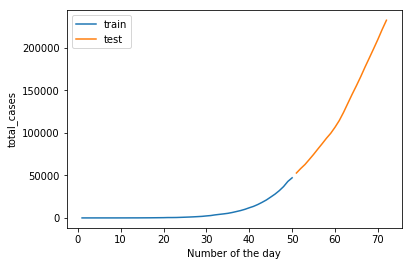

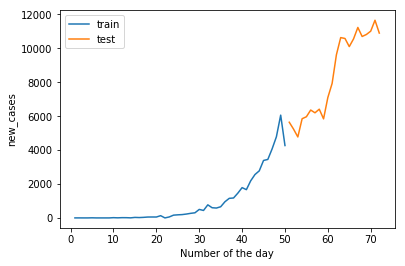

In [16]:
for col_name in df_covid_rus.columns[-3:-1]:
    plt.plot(df_train['day_count'],df_train[col_name], label = 'train')
    plt.plot(df_test['day_count'],df_test[col_name],  label = 'test')
    plt.legend()
    plt.xlabel('Number of the day')
    plt.ylabel(col_name)
    plt.show()

a). Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [17]:
def train_model(xs, ys, alpha=0, use_lasso=False):
    xs = np.array(xs).reshape(-1, 1)
    ys = np.log(np.array(ys) + 0.00001)
    if alpha == 0:
        return linear_model.LinearRegression(fit_intercept=True).fit( xs, ys )
    else:
        if use_lasso:
            return linear_model.Lasso(alpha=alpha, fit_intercept=True).fit( xs, ys )
        else:
            return linear_model.Ridge(alpha=alpha, fit_intercept=True).fit( xs, ys )

In [18]:
simple_model = train_model(df_train['day_count'], df_train['total_cases'])

[0.20328034]


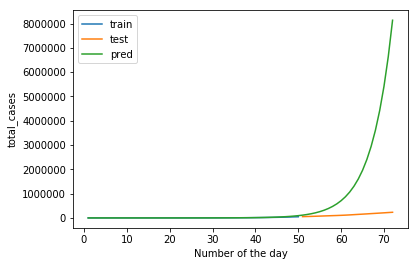

[0.32325844]


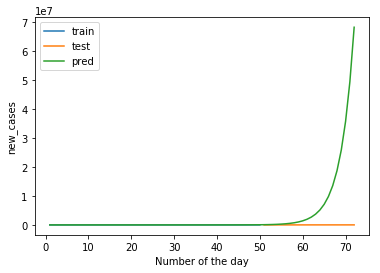

In [19]:
for col_name in df_covid_rus.columns[-3:-1]:
    model = train_model(df_train['day_count'], df_train[col_name])
    print(model.coef_)
    pred = np.exp(model.predict(pd.DataFrame(df_covid_rus['day_count'])))    
    plt.plot(df_train['day_count'],df_train[col_name], label = 'train')
    plt.plot(df_test['day_count'],df_test[col_name],  label = 'test')
    plt.plot(df_covid_rus['day_count'],pred,  label = 'pred')
    plt.legend()
    plt.xlabel('Number of the day')
    plt.ylabel(col_name)
    plt.show()

Можно пройтись гридсерчем по альфам для регуляризации, но видим, что коэффициенты и так не шибко велики, и радикального прироста качества модели мы не получим. Посмотрим чуть ближена ситуацию на трейне.


[0.20328034]


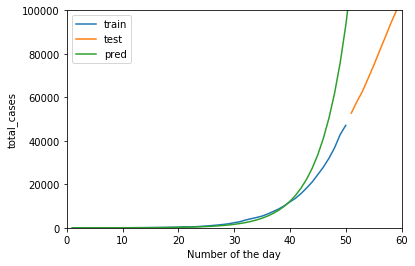

[0.32325844]


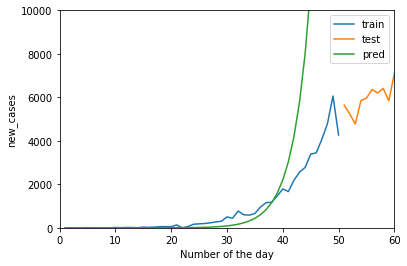

In [20]:
for col_name in df_covid_rus.columns[-3:-1]:
    model = train_model(df_train['day_count'], df_train[col_name])
    print(model.coef_)
    pred = np.exp(model.predict(pd.DataFrame(df_covid_rus['day_count'])))    
    plt.plot(df_train['day_count'],df_train[col_name], label = 'train')
    plt.plot(df_test['day_count'],df_test[col_name],  label = 'test')
    plt.plot(df_covid_rus['day_count'],pred,  label = 'pred')
    plt.legend()
    plt.xlabel('Number of the day')
    plt.ylabel(col_name)
    plt.xlim(0,60)
    if col_name == 'total_cases':
        plt.ylim(0,100000)
    else:
        plt.ylim(0,10000)
    plt.show()

Видно, что часть данных описывается моделью неплохо, но после 40го дня предсказания слишком сильно улетают от реальных данных. 

b). Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

$$p(w) = \mathcal{N}(w|\mu_0, \Sigma_0)$$
$$p(w|D) = \mathcal{N}(w| \mu_N, \Sigma_N)$$

In [21]:
model = train_model(df_train['day_count'], df_train['total_cases'],alpha=1000)
print(model.coef_)
pred = np.exp(model.predict(pd.DataFrame(df_train['day_count'])))    
var = (np.log(pred) - np.log(df_train['total_cases'])).std()**2 #найдем \sigma^2
var_zero = var/1000 
#print(var)
print(var_zero)

[0.18546826]
0.00019882113303180659


видоизменим формулу из 2 лекции со слайда 22 с учетом того, что $\mu_o = 0, t = \ln(y)$.
$$\Sigma_N = \left(\frac{I}{\sigma_0^2} + \frac{X^T X}{\sigma^2}\right)^{-1}$$
$$\mu_N = \Sigma_N\left(\frac{X^T \ln{y}}{\sigma^2}\right)$$

In [22]:
X = np.ones((len(df_train), 2)) # по аналогии с ноутбуком с занятия
X[:, 1] = df_train['day_count']
sigma_posterior = np.linalg.inv(np.eye(2) / var_zero + (X.T @ X) / var)
mu_posterior = sigma_posterior @ (X.T @ np.log(df_train['total_cases'])) / var
print('sigma = \n{},\n mu = {}'.format(sigma_posterior,mu_posterior))

sigma = 
[[ 1.96271392e-04 -5.69712066e-06]
 [-5.69712066e-06  4.69174643e-06]],
 mu = [0.02218455 0.23503727]


с). Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).


In [30]:
import scipy.stats as sps

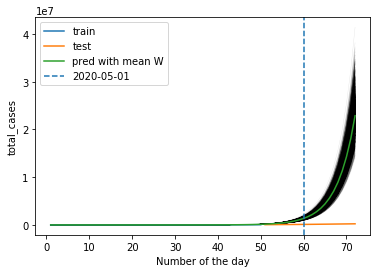

In [129]:
n=5000
X = np.ones((len(df_covid_rus), 2))
X[:, 1] = df_covid_rus['day_count']
my_w = np.random.multivariate_normal(mu_posterior, sigma_posterior, n)    
for w in my_w:
    plt.plot(X[:,1],np.exp(X@w), 'k-', lw=.4, alpha = 0.1)
plt.plot(df_train['day_count'], df_train['total_cases'], label='train')
plt.plot(df_test['day_count'], df_test['total_cases'], label='test')
plt.plot(X[:, 1], np.exp(X @ my_w.mean(axis=0)), label='pred with mean W')
for date in ['2020-05-01', '2020-06-01', '2020-09-01']:
    if (pd.to_datetime(date) - pd.to_datetime('2020-03-02')).days < 75:
        plt.axvline((pd.to_datetime(date) - pd.to_datetime('2020-03-02')).days, linestyle = '--', label = date)
plt.xlabel('Number of the day')
plt.ylabel('total_cases')
plt.legend()

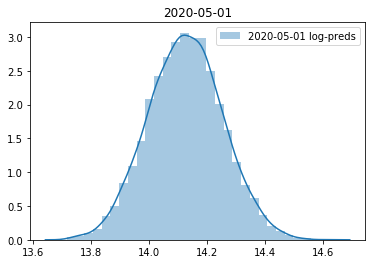

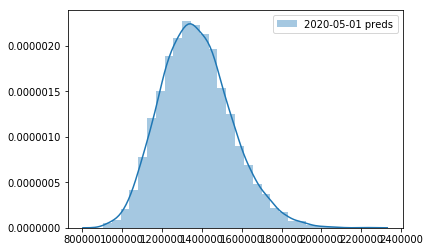

Mean log-prediction for 2020-05-01 is 14.12, mean prediction is 1373593 people


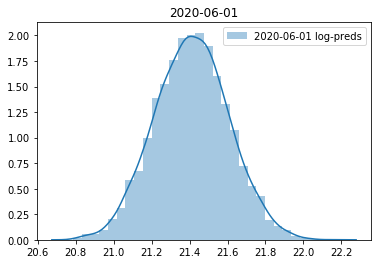

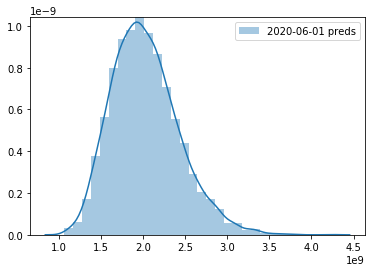

Mean log-prediction for 2020-06-01 is 21.41, mean prediction is 2027613172 people


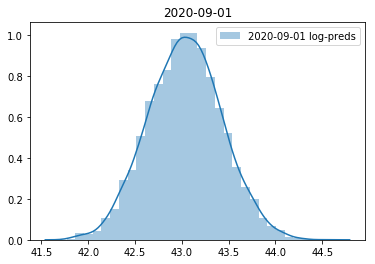

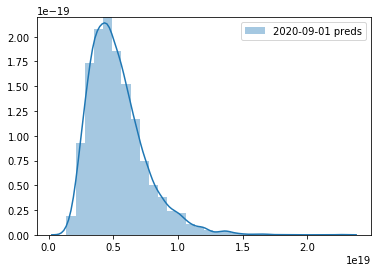

Mean log-prediction for 2020-09-01 is 43.04, mean prediction is 5292698352849486848 people


In [130]:
for date in ['2020-05-01', '2020-06-01', '2020-09-01']:    
    preds = np.zeros(my_w.shape[0])
    x = np.array([1, (pd.to_datetime(date) - pd.to_datetime('2020-03-02')).days])
    for w in range(my_w.shape[0]):
        preds[w] = x @ my_w[w, :]
    preds = pd.Series((preds))    
    sns.distplot(preds, bins=30,label = date + ' log-preds')
    plt.title(date)
    plt.legend()
    plt.show()
    preds_exp = pd.Series(np.exp(preds))
    sns.distplot(preds_exp, bins=30,label = date + ' preds')
    plt.ticklabel_format(style='sci', axis='x')
    plt.legend()
    plt.show()
    print(f'Mean log-prediction for {date} is {((preds).mean()):.2f}, mean prediction is {int(np.exp(preds).mean())} people')